In [52]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np

import statsmodels.formula.api as sm

#%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

In [53]:
#df_pe_original = pd.read_csv('DKA - Physical.csv')
df_pe_original = pd.read_csv('PHYSEXAM.csv')

df_pe_original.head()

pd.set_option('display.max_columns', None) # View max columns
print(df_pe_original.columns.to_list())

df_pe_original.head()

['PUDID', 'StudyEvent', 'Occurrence', 'ItemGroupRepeatKey', 'PETime', 'PEHEENT', 'PEHEENTDesc', 'PECardio', 'PECardioDesc', 'PEResp', 'PERespDesc', 'PEGI', 'PEGIDesc', 'PEHepatic', 'PEHepaticDesc', 'PEGU', 'PEGUDesc', 'PERenal', 'PERenalDesc', 'PENeuro', 'PENeuroDesc', 'PEPsych', 'PEPsychDesc', 'PEEndo', 'PEEndoDesc', 'PEHema', 'PEHemaDesc', 'PEMusculo', 'PEMusculoDesc', 'PEDerm', 'PEDermDesc', 'PEAllergies', 'PEAllergiesDesc', 'PEImmune', 'PEImmuneDesc', 'PEAlcohol', 'PEAlcoholDesc', 'PEDAY']


,PUDID,StudyEvent,Occurrence,ItemGroupRepeatKey,PETime,PEHEENT,PEHEENTDesc,PECardio,PECardioDesc,PEResp,PERespDesc,PEGI,PEGIDesc,PEHepatic,PEHepaticDesc,PEGU,PEGUDesc,PERenal,PERenalDesc,PENeuro,PENeuroDesc,PEPsych,PEPsychDesc,PEEndo,PEEndoDesc,PEHema,PEHemaDesc,PEMusculo,PEMusculoDesc,PEDerm,PEDermDesc,PEAllergies,PEAllergiesDesc,PEImmune,PEImmuneDesc,PEAlcohol,PEAlcoholDesc,PEDAY
0,1,Study Initiation,0,0,1750,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,0
1,2,Study Initiation,0,0,1145,Normal,NaN,Abnormal,Tachycardic HR 120,Abnormal,"Tachypnea, RR 24",Abnormal,Vomiting,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,Lethargic,Normal,NaN,Abnormal,DKA,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0
2,3,Study Initiation,0,0,1240,Abnormal,dry mouth,Abnormal,"capillary refill ~ 5 seconds, weak peripheral ...",Abnormal,Kussmaul's respirations,Normal,NaN,Normal,NaN,Not Assessed,NaN,Abnormal,large urine output in ED,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,0
3,4,Study Initiation,0,0,1354,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,thin/cachectic,Normal,NaN,Normal,NaN,Abnormal,"bruise on arm, scab on knee",Normal,NaN,Normal,NaN,Normal,NaN,0
4,5,Study Initiation,0,0,1432,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Abnormal,diffuse tenderness to palpation,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0


In [54]:
#Checking - are these all study initiation events? - yes
df_pe_original['StudyEvent'].value_counts() 
df_pe_original['PUDID'].nunique() #1389 - ok, one row per patient
#len(df_pe_original) #1389

1389

In [55]:
# This cell is duplicated via function in the cell below now
df_pe = df_pe_original[['PUDID', 'PETime', 'PEHEENT', 'PEHEENTDesc', 'PECardio', 'PECardioDesc', 
                        'PEResp', 'PERespDesc', 'PEGI', 'PEGIDesc', 'PEHepatic', 'PEHepaticDesc', 
                        'PEGU', 'PEGUDesc', 'PERenal', 'PERenalDesc', 'PENeuro', 'PENeuroDesc', 
                        'PEPsych', 'PEPsychDesc', 'PEEndo', 'PEEndoDesc', 'PEHema', 'PEHemaDesc', 
                        'PEMusculo', 'PEMusculoDesc', 'PEDerm', 'PEDermDesc', 'PEAllergies', 
                        'PEAllergiesDesc', 'PEImmune', 'PEImmuneDesc', 'PEAlcohol', 'PEAlcoholDesc', 
                        'PEDAY']].copy()  # <-- Use .copy() to avoid issues

df_pe.loc[:, 'HEENT_Class'] = df_pe['PEHEENT'].apply(lambda x: 1 if x == 'Abnormal' else 0)
df_pe['PEHEENT'] = df_pe['PEHEENT'].str.strip()
df_pe.loc[:, 'Cardio_Class'] = df_pe['PECardio'].apply(lambda x: 1 if x == 'Abnormal' else 0)
df_pe['PECardio'] = df_pe['PECardio'].str.strip()
df_pe.loc[:, 'Resp_Class'] = df_pe['PEResp'].apply(lambda x: 1 if x == 'Abnormal' else 0)
df_pe['PEResp'] = df_pe['PEResp'].str.strip()
df_pe.loc[:, 'GI_Class'] = df_pe['PEGI'].apply(lambda x: 1 if x == 'Abnormal' else 0)
df_pe['PEGI'] = df_pe['PEGI'].str.strip()
df_pe.loc[:, 'Hepatic_Class'] = df_pe['PEHepatic'].apply(lambda x: 1 if x == 'Abnormal' else 0)
df_pe['PEHepatic'] = df_pe['PEHepatic'].str.strip()
df_pe.loc[:, 'GU_Class'] = df_pe['PEGU'].apply(lambda x: 1 if x == 'Abnormal' else 0)
df_pe['PEGU'] = df_pe['PEGU'].str.strip()
df_pe.loc[:, 'Renal_Class'] = df_pe['PERenal'].apply(lambda x: 1 if x == 'Abnormal' else 0)
df_pe['PERenal'] = df_pe['PERenal'].str.strip()
df_pe.loc[:, 'Neuro_Class'] = df_pe['PENeuro'].apply(lambda x: 1 if x == 'Abnormal' else 0)
df_pe['PENeuro'] = df_pe['PENeuro'].str.strip()
df_pe.loc[:, 'Psych_Class'] = df_pe['PEPsych'].apply(lambda x: 1 if x == 'Abnormal' else 0)
df_pe['PEPsych'] = df_pe['PEPsych'].str.strip()
df_pe.loc[:, 'Endo_Class'] = df_pe['PEEndo'].apply(lambda x: 1 if x == 'Abnormal' else 0)
df_pe['PEEndo'] = df_pe['PEEndo'].str.strip()
df_pe.loc[:, 'Heme_Class'] = df_pe['PEHema'].apply(lambda x: 1 if x == 'Abnormal' else 0)
df_pe['PEHema'] = df_pe['PEHema'].str.strip()
df_pe.loc[:, 'MSK_Class'] = df_pe['PEMusculo'].apply(lambda x: 1 if x == 'Abnormal' else 0)
df_pe['PEMusculo'] = df_pe['PEMusculo'].str.strip()
df_pe.loc[:, 'Derm_Class'] = df_pe['PEDerm'].apply(lambda x: 1 if x == 'Abnormal' else 0)
df_pe['PEDerm'] = df_pe['PEDerm'].str.strip()
df_pe.loc[:, 'Allergy_Class'] = df_pe['PEAllergies'].apply(lambda x: 1 if x == 'Abnormal' else 0)
df_pe['PEAllergies'] = df_pe['PEAllergies'].str.strip()
df_pe.loc[:, 'Immune_Class'] = df_pe['PEImmune'].apply(lambda x: 1 if x == 'Abnormal' else 0)
df_pe['PEImmune'] = df_pe['PEImmune'].str.strip()
df_pe.loc[:, 'Alcohol_Class'] = df_pe['PEAlcohol'].apply(lambda x: 1 if x == 'Abnormal' else 0)
df_pe['PEAlcohol'] = df_pe['PEAlcohol'].str.strip()

#display head 
df_pe.head()

,PUDID,PETime,PEHEENT,PEHEENTDesc,PECardio,PECardioDesc,PEResp,PERespDesc,PEGI,PEGIDesc,PEHepatic,PEHepaticDesc,PEGU,PEGUDesc,PERenal,PERenalDesc,PENeuro,PENeuroDesc,PEPsych,PEPsychDesc,PEEndo,PEEndoDesc,PEHema,PEHemaDesc,PEMusculo,PEMusculoDesc,PEDerm,PEDermDesc,PEAllergies,PEAllergiesDesc,PEImmune,PEImmuneDesc,PEAlcohol,PEAlcoholDesc,PEDAY,HEENT_Class,Cardio_Class,Resp_Class,GI_Class,Hepatic_Class,GU_Class,Renal_Class,Neuro_Class,Psych_Class,Endo_Class,Heme_Class,MSK_Class,Derm_Class,Allergy_Class,Immune_Class,Alcohol_Class
0,1,1750,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1145,Normal,NaN,Abnormal,Tachycardic HR 120,Abnormal,"Tachypnea, RR 24",Abnormal,Vomiting,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,Lethargic,Normal,NaN,Abnormal,DKA,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0
2,3,1240,Abnormal,dry mouth,Abnormal,"capillary refill ~ 5 seconds, weak peripheral ...",Abnormal,Kussmaul's respirations,Normal,NaN,Normal,NaN,Not Assessed,NaN,Abnormal,large urine output in ED,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,4,1354,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,thin/cachectic,Normal,NaN,Normal,NaN,Abnormal,"bruise on arm, scab on knee",Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,5,1432,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Abnormal,diffuse tenderness to palpation,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [56]:
# Above converted to a function
def one_hot_encode(df, finding_columns):
    """
    One-hot encodes columns from df. If 'Abnormal', then 1.
    Strips whitespace from original column
    Returns df
    """

    for col in finding_columns:
        class_col = f'{col[2:]}_Class'  # Create class column name (e.g., HEENT_Class)
        df.loc[:, class_col] = df[col].apply(lambda x: 1 if x == 'Abnormal' else 0)
        df[col] = df[col].str.strip()

    return df

df_pe = df_pe_original[['PUDID', 'PETime', 'PEHEENT', 'PEHEENTDesc', 'PECardio', 'PECardioDesc', 
                        'PEResp', 'PERespDesc', 'PEGI', 'PEGIDesc', 'PEHepatic', 'PEHepaticDesc', 
                        'PEGU', 'PEGUDesc', 'PERenal', 'PERenalDesc', 'PENeuro', 'PENeuroDesc', 
                        'PEPsych', 'PEPsychDesc', 'PEEndo', 'PEEndoDesc', 'PEHema', 'PEHemaDesc', 
                        'PEMusculo', 'PEMusculoDesc', 'PEDerm', 'PEDermDesc', 'PEAllergies', 
                        'PEAllergiesDesc', 'PEImmune', 'PEImmuneDesc', 'PEAlcohol', 'PEAlcoholDesc', 
                        'PEDAY']].copy()
finding_columns = [
    'PEHEENT', 'PECardio', 'PEResp', 'PEGI', 'PEHepatic', 'PEGU', 'PERenal', 'PENeuro', 'PEPsych', 'PEEndo', 'PEHema', 'PEMusculo', 
    'PEDerm','PEAllergies', 'PEImmune', 'PEAlcohol']

one_hot_encode(df_pe, finding_columns)
df_pe.head()

,PUDID,PETime,PEHEENT,PEHEENTDesc,PECardio,PECardioDesc,PEResp,PERespDesc,PEGI,PEGIDesc,PEHepatic,PEHepaticDesc,PEGU,PEGUDesc,PERenal,PERenalDesc,PENeuro,PENeuroDesc,PEPsych,PEPsychDesc,PEEndo,PEEndoDesc,PEHema,PEHemaDesc,PEMusculo,PEMusculoDesc,PEDerm,PEDermDesc,PEAllergies,PEAllergiesDesc,PEImmune,PEImmuneDesc,PEAlcohol,PEAlcoholDesc,PEDAY,HEENT_Class,Cardio_Class,Resp_Class,GI_Class,Hepatic_Class,GU_Class,Renal_Class,Neuro_Class,Psych_Class,Endo_Class,Hema_Class,Musculo_Class,Derm_Class,Allergies_Class,Immune_Class,Alcohol_Class
0,1,1750,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1145,Normal,NaN,Abnormal,Tachycardic HR 120,Abnormal,"Tachypnea, RR 24",Abnormal,Vomiting,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,Lethargic,Normal,NaN,Abnormal,DKA,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0
2,3,1240,Abnormal,dry mouth,Abnormal,"capillary refill ~ 5 seconds, weak peripheral ...",Abnormal,Kussmaul's respirations,Normal,NaN,Normal,NaN,Not Assessed,NaN,Abnormal,large urine output in ED,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,4,1354,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,thin/cachectic,Normal,NaN,Normal,NaN,Abnormal,"bruise on arm, scab on knee",Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,5,1432,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Abnormal,diffuse tenderness to palpation,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
#Data cleaning

#should we have different df for each system? I do not think so but will need to do a lot of replacing 
#HEENT - going to have to combine everything that says a version of dry mouth, dry mucous etc. into a single term - even some things that say 'Tacky M'
#Cardio - tachycardic and all versions of that spelling
#Resp - Kussmaul and all versions of that spelling, tachypnic 
#GI - all terms associated with abdominal tenderness, nausea/emesis
#GU - polyuria and anything mentioning increased urine output
#Renal - polyuria as above, will have to be careful not to double count 
#Neuro - this part is going to be really hard, possibly should just use GCS for this part 
#Psych - Tired, altered, etc. 
#Endo - hyperglycemia/history of DKA?

In [58]:
def create_binary_flag(df, description_column, new_column, search_patterns, regex=False):
    """
    Creates a binary flag based on the presence of specified search patterns in the description column.
    regex = False -> treated as literal strings. When regex = True, you can use regex in the search_patterns
    """

    if description_column not in df.columns:
        raise ValueError(f"'{description_column}' not found in {df} columns.")
    if not search_patterns:
        return df

    df[new_column] = 0
    df.loc[df[description_column].isna(), new_column] = np.nan

    for pattern in search_patterns:
        df.loc[df[description_column].str.lower() == pattern.lower(), new_column] = 1

    for pattern in search_patterns:
        if regex:
            df.loc[df[description_column].str.contains(pattern, case=False, na=False, regex=True) & (df[new_column] == 0), new_column] = 1
        else:
            df.loc[df[description_column].str.contains(pattern, case=False, na=False, regex=False) & (df[new_column] == 0), new_column] = 1

    return df

# HEENT Dry_MM
df_pe = create_binary_flag(df_pe, 'PEHEENTDesc', 'HEENT_DryMM', ["dry muc", "drymm", "dry lip"], regex=True)

# Cardio Tachy:
df_pe = create_binary_flag(df_pe, 'PECardioDesc', 'Cardio_Tachy', ["tachycardic", "tachycardia"])

# Resp Tachy - we will need to include all cases or do regex to figure out how to do it with capitals etc.
df_pe = create_binary_flag(df_pe, 'PERespDesc', 'Resp_Tachy', ['tachypnea','Tachypnea','tachycardia', 'Tachypneic'])

# Resp Kuss: This is going to have to contain every version of the spelling because it is spelled wrong a lot 
df_pe = create_binary_flag(df_pe, 'PERespDesc', 'Resp_Kuss', ['Kuss', ], regex=True)

# GI - Tender

#GI - Nausea/Vomiting

#GU - Polyuria + Frequency + Urinating alot + Increased Urination

#Renal - we might have to combine renal and GU because they both say polyuria (not sure if you can do that with create_binary

#Neuro - Sleepy/Lethargic/Altered Mental Status/Somnolent/Listless/Fatigued/Tired/Drowsy

#Psych - Agitated/Distressed/Irritable/

#Endo - I am not sure what to do with this one but I am inclined to leave it out or only use ketotic breath/acetone breath

#MSK - Thin - 'Cachectic'- 'Thin-appearing' 'Thin extremities' etc. 

#MSK - Muscle Pain - 'Myalgia' 'Muscle Pain' 

# DERM - Pallor/Pale skin

# DERM - Dry skin


print(df_pe.head(10))

   PUDID  PETime   PEHEENT                           PEHEENTDesc  PECardio  \
0      1    1750    Normal                                   NaN    Normal   
1      2    1145    Normal                                   NaN  Abnormal   
2      3    1240  Abnormal                             dry mouth  Abnormal   
3      4    1354  Abnormal                  dry mucous membranes    Normal   
4      5    1432  Abnormal                  dry mucous membranes    Normal   
5      6    1029    Normal                                   NaN  Abnormal   
6      7    1216    Normal                                   NaN  Abnormal   
7      8    1855  Abnormal                            dry mucosa    Normal   
8      9    1855    Normal                                   NaN    Normal   
9     10    2140  Abnormal  dry mucous membranes, injection eyes  Abnormal   

                                        PECardioDesc    PEResp  \
0                                                NaN    Normal   
1        

In [59]:
#covnerting PETime to datetime

#first convert to string for date time function
df_pe['PETime'] = (df_pe['PETime']).astype(str)

#some values are single digits - assuming there are leading zeros
df_pe.loc[df_pe["PETime"] == "0", "PETime"] = "0000"
df_pe.loc[df_pe["PETime"] == "1", "PETime"] = "0001"
df_pe.loc[df_pe["PETime"] == "2", "PETime"] = "0002"
df_pe.loc[df_pe["PETime"] == "4", "PETime"] = "0004"
df_pe.loc[df_pe["PETime"] == "9", "PETime"] = "0009"

#convert to time
df_pe['PETime'] = pd.to_datetime(df_pe['PETime'], format='%H%M').dt.time# Print the DataFrameprint(df)
df_pe.head()

,PUDID,PETime,PEHEENT,PEHEENTDesc,PECardio,PECardioDesc,PEResp,PERespDesc,PEGI,PEGIDesc,PEHepatic,PEHepaticDesc,PEGU,PEGUDesc,PERenal,PERenalDesc,PENeuro,PENeuroDesc,PEPsych,PEPsychDesc,PEEndo,PEEndoDesc,PEHema,PEHemaDesc,PEMusculo,PEMusculoDesc,PEDerm,PEDermDesc,PEAllergies,PEAllergiesDesc,PEImmune,PEImmuneDesc,PEAlcohol,PEAlcoholDesc,PEDAY,HEENT_Class,Cardio_Class,Resp_Class,GI_Class,Hepatic_Class,GU_Class,Renal_Class,Neuro_Class,Psych_Class,Endo_Class,Hema_Class,Musculo_Class,Derm_Class,Allergies_Class,Immune_Class,Alcohol_Class,HEENT_DryMM,Cardio_Tachy,Resp_Tachy,Resp_Kuss
0,1,17:50:00,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
1,2,11:45:00,Normal,NaN,Abnormal,Tachycardic HR 120,Abnormal,"Tachypnea, RR 24",Abnormal,Vomiting,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,Lethargic,Normal,NaN,Abnormal,DKA,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,NaN,1.0,1.0,0.0
2,3,12:40:00,Abnormal,dry mouth,Abnormal,"capillary refill ~ 5 seconds, weak peripheral ...",Abnormal,Kussmaul's respirations,Normal,NaN,Normal,NaN,Not Assessed,NaN,Abnormal,large urine output in ED,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0
3,4,13:54:00,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,thin/cachectic,Normal,NaN,Normal,NaN,Abnormal,"bruise on arm, scab on knee",Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1.0,NaN,NaN,NaN
4,5,14:32:00,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Abnormal,diffuse tenderness to palpation,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1.0,NaN,NaN,NaN


*Demographics*
* Sex = Sex
* Ethnicity = Ethnicity 
* Race 1 = American Indian or Alaska Native 
* Race 2 = Asian
* Race 3 = Black or African American
* Race 3 = Native Hawaiian or Other Pacific Islander 
* Race 5 = White
* Race 92 = Unknown or Not Reported
* AgeInYears = Age in years

In [60]:
df_demo = pd.read_csv('Demographics.csv')

df_demo = df_demo[['PUDID', 'Sex', 'Ethnicity', 'Race1', 'Race2', 'Race3', 'Race4', 'Race5', 'Race92', 'AgeInYears']]

#Rename the columns 
df_demo = df_demo.rename(columns={
    'Race1': 'American Indian or Alaska Native',
    'Race2': 'Asian',
    'Race3': 'Black or African American',
    'Race4': 'Native Hawaiian or Other Pacific Islander',
    'Race5': 'White',
    'Race92': 'Unknown or Not Reported',
    'AgeInYears': 'Age'
})

#Total number of patients
total = len(df_demo['PUDID'])
print("Total number of patients:", total)

# Create a dictionary to store value counts for each category
summary_data = {
    'Sex': df_demo['Sex'].value_counts(),
    'Ethnicity': df_demo['Ethnicity'].value_counts(),
    'American Indian or Alaska Native': df_demo['American Indian or Alaska Native'].value_counts(), 
    'Asian': df_demo['Asian'].value_counts(),
    'Black or African American': df_demo['Black or African American'].value_counts(),
    'Native Hawaiian or Other Pacific Islander': df_demo['Native Hawaiian or Other Pacific Islander'].value_counts(),
    'White': df_demo['White'].value_counts(),
    'Unknown or Not Reported': df_demo['Unknown or Not Reported'].value_counts(),
}

#Convert dictionary to DataFrame
summary_df = pd.DataFrame(summary_data)

# Display the summary table
print(summary_df)

df_demo['Age'].describe(percentiles = [.25, .5, .75])

Total number of patients: 1389
                          Sex  Ethnicity  American Indian or Alaska Native  \
Female                  739.0        NaN                               NaN   
Hispanic or Latino        NaN      228.0                               NaN   
Male                    650.0        NaN                               NaN   
No                        NaN        NaN                            1369.0   
Not Hispanic or Latino    NaN     1109.0                               NaN   
Unknown                   NaN       52.0                               NaN   
Yes                       NaN        NaN                              20.0   

                         Asian  Black or African American  \
Female                     NaN                        NaN   
Hispanic or Latino         NaN                        NaN   
Male                       NaN                        NaN   
No                      1374.0                     1063.0   
Not Hispanic or Latino     NaN         

count    1389.000000
mean       11.607329
std         4.072595
min         0.536986
25%         9.224216
50%        12.221918
75%        14.632877
max        17.994521
Name: Age, dtype: float64

*Creating simple figures for demographics*

In [101]:
#import matplot lib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

<Figure size 1000x600 with 0 Axes>

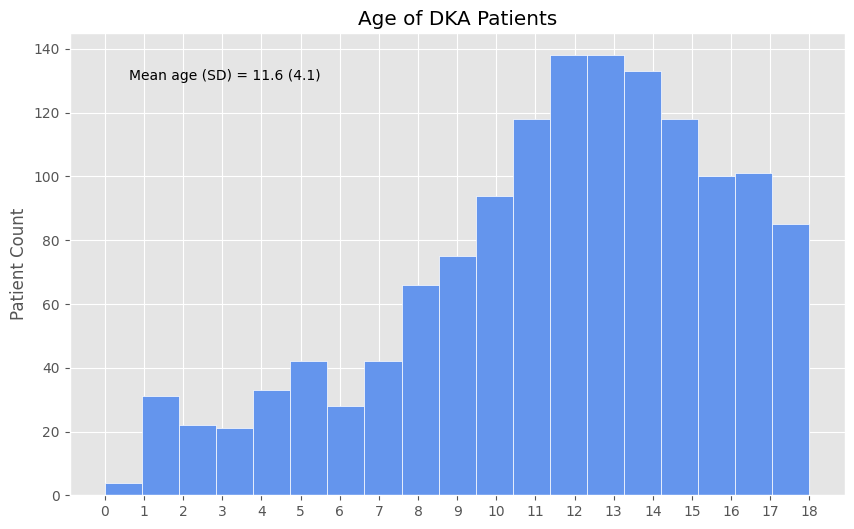

In [102]:
#histogram for age
fig = plt.figure(figsize = (10,6))

fig, ax = plt.subplots()
ax.hist(df_demo['Age'],
        bins = 19,
        range = (0,18),
                color = 'cornflowerblue',
       edgecolor = 'white') 
ax.set_title("Age of DKA Patients")
ax.set_ylabel("Patient Count")
ax.text(0.2, 0.9, "Mean age (SD) = 11.6 (4.1)", fontsize=10, ha="center", transform=ax.transAxes)
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.show()

In [ ]:
#counts for demographics
fig = plt.figure(figsize = (10,6))

fig, ax = plt.subplots()
ax.hist(df_demo['Age'],
        bins = 19,
        range = (0,18),
                color = 'cornflowerblue',
       edgecolor = 'white') 
ax.set_title("Age of DKA Patients")
ax.set_ylabel("Patient Count")
ax.text(0.2, 0.9, "Mean age (SD) = 11.6 (4.1)", fontsize=10, ha="center", transform=ax.transAxes)

In [61]:
#HEENT

# #Create Dry_MM column
# df['HEENT_DryMM'] = 0

# # #Apply sequential filters
# df.loc[df['PEHEENTDesc'].str.contains('dry muc', case=False, na=False), 'HEENT_DryMM'] = 1
# df.loc[df['PEHEENTDesc'].str.contains('drymm', case=False, na=False), 'HEENT_DryMM'] = 1
# df.loc[df['PEHEENTDesc'].str.contains('dry lip', case=False, na=False), 'HEENT_DryMM'] = 1


# #print(df[df['PEHEENTDesc'].str.contains("dry mucous", case = False, na = False)])
# # df.dtypes
# df.head(20)

In [62]:
#Cardio

#Create tachycardio column
df['Cardio_Tachy'] = 0

#Apply sequential filters
df.loc[df['PECardioDesc'] == 'tachycardic', 'Cardio_Tachy'] = 1
df.loc[df['PECardioDesc'] == 'tachycardia', 'Cardio_Tachy'] = 1
df.loc[df['PECardioDesc'].str.contains('tachycardic', case=False, na=False), 'Cardio_Tachy'] = 1
df.loc[df['PECardioDesc'].str.contains('tachycardia', case=False, na=False), 'Cardio_Tachy'] = 1

# df.dtypes
df.head(20)

NameError: name 'df' is not defined

In [ ]:
##Resp 

#Create tachypnea column
df['Resp_Tachy'] = 0

#Create Kussmaul
df['Resp_Kuss'] = 0

#Apply sequential filters to resp_tachy
df.loc[df['PERespDesc'] == 'tachypnea', 'Resp_Tachy'] = 1
df.loc[df['PERespDesc'] == 'tachycardia', 'Resp_Tachy'] = 1

#Apply sequential filters to resp_kuss
#df.loc[df['PERespDesc'] == 'Kussmaul', 'Resp_Kuss'] = 1
df.loc[df['PERespDesc'].str.contains('Kuss', case=False, na=False), 'Resp_Kuss'] = 1

df.head(10)

In [ ]:
##GI 

#Create abdominal pain column
df['GI_Pain'] = 0

#Create Kussmaul
df[''] = 0